## Predicting where to setup a restaurant in the City of New York (With Venue Feature Analysis)

Downloading all the dependencies

In [84]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [85]:
pip install pandasql

Note: you may need to restart the kernel to use updated packages.


## 1. Download and Explore Dataset

In [86]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [87]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [88]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [89]:
neighborhoods_data = newyork_data['features']

In [90]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transforming data in Pandas Dataframe

In [91]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [92]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.shape

(306, 4)

In [93]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Using geopy library to get the latitude and longitude values of New York City.

In [94]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [95]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Creating new Dataframe for manhattan data

In [96]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

In [97]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Visualizing Manhattan Neighborhoods

In [335]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### Defining Foursquare Credentials and Version

In [99]:
CLIENT_ID = 'TT04R0LTPHZX2CB23F23SFKOXJDB55WCUZXGVGOZSHJIVCPE' # your Foursquare ID
CLIENT_SECRET = 'ID1H4YLZ0TLITLFTGSYRMWAT0SR5EUX5MCDI0M4VE554A0TB' # your Foursquare Secret
VERSION = '20200501' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TT04R0LTPHZX2CB23F23SFKOXJDB55WCUZXGVGOZSHJIVCPE
CLIENT_SECRET:ID1H4YLZ0TLITLFTGSYRMWAT0SR5EUX5MCDI0M4VE554A0TB


In [100]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500
radius = 500 # define radius


## 2. Explore Neighborhoods in Manhattan

In [101]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'], 
            v['venue']['id']) for v in results]) 

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue_Category',
                  'Venue ID']
    
    return(nearby_venues)

In [102]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [103]:
print(manhattan_venues.shape)
manhattan_venues.shape

(3071, 8)


(3071, 8)

Creating a Manhattan Restaurants Dataframe

In [104]:
manhattan_restaurants = manhattan_venues[manhattan_venues['Venue_Category'].str.contains("Restaurant")].reset_index(drop=True)
print(manhattan_restaurants.shape)
manhattan_restaurants.head()

(816, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category,Venue ID
0,Marble Hill,40.876551,-73.910660,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,4b9c9c6af964a520b27236e3
1,Marble Hill,40.876551,-73.910660,Boston Market,40.877430,-73.905412,American Restaurant,585c205665e7c70a2f1055ea
2,Chinatown,40.715618,-73.994279,Kiki's,40.714476,-73.992036,Greek Restaurant,5521c2ff498ebe2368634187
3,Chinatown,40.715618,-73.994279,The Fat Radish,40.715323,-73.991950,English Restaurant,4c9d482e46978cfa8247967f
4,Chinatown,40.715618,-73.994279,Da Yu Hot Pot 大渝火锅,40.716735,-73.995752,Hotpot Restaurant,5d992946dbf3ca0008d05211


In [105]:
manhattan_restaurants.to_csv('manhattan_restaurants.csv')

Checking number of restaurants returned for each neighborhood

In [106]:
manhattan_restaurants.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category,Venue ID
Neighborhood,,,,,,,
Battery Park City,3,3,3,3,3,3,3
Carnegie Hill,19,19,19,19,19,19,19
Central Harlem,15,15,15,15,15,15,15
Chelsea,14,14,14,14,14,14,14
Chinatown,39,39,39,39,39,39,39
Civic Center,26,26,26,26,26,26,26
Clinton,17,17,17,17,17,17,17
East Harlem,15,15,15,15,15,15,15
East Village,36,36,36,36,36,36,36


In [107]:
print('There are {} uniques Restaurants.'.format(len(manhattan_restaurants['Venue_Category'].unique())))

There are 76 uniques Restaurants.


## 3. Analyze Each Neighborhood

In [108]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_restaurants[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [109]:
print(manhattan_onehot.shape)

(816, 77)


#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [110]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Persian Restaurant,Peruvian Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Battery Park City,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,Carnegie Hill,0.0,0.0,0.052632,0.0,0.052632,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.052632,0.0,0.105263,0.0,0.000000,0.0,0.000000,0.052632,0.0,0.105263,0.0,0.157895,0.0,0.0,0.000000,0.052632,0.0,0.0,0.000000,0.000000,0.052632,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.052632,0.052632,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.052632,0.0,0.0,0.000000,0.0,0.052632,0.0,0.0,0.000000,0.105263
2,Central Harlem,0.0,0.2,0.133333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.066667,0.0,0.200000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.066667,0.0,0.000000,0.0,0.133333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.133333,0.000000,0.0,0.0,0.0,0.066667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,Chelsea,0.0,0.0,0.214286,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.071429,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.071429,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.071429,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.071429,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,Chinatown,0.0,0.0,0.076923,0.0,0.000000,0.051282,0.025641,0.025641,0.0,0.0,0.025641,0.000000,0.0,0.179487,0.0,0.0,0.051282,0.051282,0.0,0.0,0.0,0.025641,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.051282,0.0,0.025641,0.000000,0.0,0.025641,0.0,0.000000,0.0,0.0,0.025641,0.000000,0.0,0.0,0.051282,0.000000,0.051282,0.000000,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.051282,0.0,0.0,0.0,0.00000

In [111]:
manhattan_grouped.shape

(39, 77)

In [112]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                      venue  freq
0  Mediterranean Restaurant  0.33
1        Mexican Restaurant  0.33
2        Chinese Restaurant  0.33
3         Afghan Restaurant  0.00
4   North Indian Restaurant  0.00


----Carnegie Hill----
                   venue  freq
0    Japanese Restaurant  0.16
1  Vietnamese Restaurant  0.11
2      French Restaurant  0.11
3     Italian Restaurant  0.11
4       Ramen Restaurant  0.05


----Central Harlem----
                 venue  freq
0   Chinese Restaurant  0.20
1   African Restaurant  0.20
2  American Restaurant  0.13
3   Seafood Restaurant  0.13
4    French Restaurant  0.13


----Chelsea----
                       venue  freq
0        American Restaurant  0.21
1         Seafood Restaurant  0.14
2         Italian Restaurant  0.14
3  Middle Eastern Restaurant  0.07
4           Ramen Restaurant  0.07


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.18
1    American Restaurant  0.08
2  Vietnamese Restau

#### Let's put that into a *pandas* dataframe

In [113]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [114]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Battery Park City,Chinese Restaurant,Mediterranean Restaurant,Mexican Restaurant
1,Carnegie Hill,Japanese Restaurant,Italian Restaurant,French Restaurant
2,Central Harlem,African Restaurant,Chinese Restaurant,American Restaurant
3,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant
4,Chinatown,Chinese Restaurant,American Restaurant,Vietnamese Restaurant
5,Civic Center,French Restaurant,American Restaurant,Sushi Restaurant
6,Clinton,Italian Restaurant,American Restaurant,Thai Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant
8,East Village,Mexican Restaurant,Japanese Restaurant,Ramen Restaurant
9,Financial District,American Restaurant,Falafel Restaurant,Japanese Restaurant


## 4. Cluster Neighborhoods

In [115]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0,
       4, 1, 1, 1, 1, 1, 3, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2], dtype=int32)

In [118]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.dropna(inplace = True)
manhattan_merged



,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4.0,American Restaurant,Seafood Restaurant,Vietnamese Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,0.0,Chinese Restaurant,American Restaurant,Vietnamese Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0.0,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0.0,Mexican Restaurant,Restaurant,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,Mexican Restaurant,Sushi Restaurant,Indian Restaurant
5,Manhattan,Manhattanville,40.816934,-73.957385,0.0,Seafood Restaurant,Italian Restaurant,Sushi Restaurant
6,Manhattan,Central Harlem,40.815976,-73.943211,0.0,African Restaurant,Chinese Restaurant,American Restaurant
7,Manhattan,East Harlem,40.792249,-73.944182,0.0,Mexican Restaurant,Latin American Restaurant,Thai Restaurant
8,Manhattan,Upper East Side,40.775639,-73.960508,2.0,Italian Restaurant,Sushi Restaurant,American Restaurant
9,Manhattan,Yorkville,40.775930,-73.947118,2.0,Italian Restaurant,Sushi Restaurant,Japanese Restaurant


In [229]:
manhattan_merged['Cluster Labels'] = manhattan_merged['Cluster Labels'].astype(int)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [120]:
a_cluster = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
a_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Chinatown,Chinese Restaurant,American Restaurant,Vietnamese Restaurant
2,Washington Heights,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant
3,Inwood,Mexican Restaurant,Restaurant,Chinese Restaurant
4,Hamilton Heights,Mexican Restaurant,Sushi Restaurant,Indian Restaurant
5,Manhattanville,Seafood Restaurant,Italian Restaurant,Sushi Restaurant
6,Central Harlem,African Restaurant,Chinese Restaurant,American Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant
19,East Village,Mexican Restaurant,Japanese Restaurant,Ramen Restaurant
20,Lower East Side,Chinese Restaurant,Vietnamese Restaurant,Mediterranean Restaurant
22,Little Italy,Chinese Restaurant,Mediterranean Restaurant,Thai Restaurant


In [121]:
b_cluster = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
b_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,Midtown,Japanese Restaurant,Cuban Restaurant,Mediterranean Restaurant
16,Murray Hill,Japanese Restaurant,Mediterranean Restaurant,Indian Restaurant
17,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant
26,Morningside Heights,American Restaurant,Mexican Restaurant,Ethiopian Restaurant
29,Financial District,American Restaurant,Falafel Restaurant,Japanese Restaurant
30,Carnegie Hill,Japanese Restaurant,Italian Restaurant,French Restaurant
31,Noho,Italian Restaurant,Japanese Restaurant,Mexican Restaurant
32,Civic Center,French Restaurant,American Restaurant,Sushi Restaurant
33,Midtown South,Korean Restaurant,Japanese Restaurant,American Restaurant
38,Flatiron,Italian Restaurant,Mediterranean Restaurant,Japanese Restaurant


In [122]:
c_cluster = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
c_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
8,Upper East Side,Italian Restaurant,Sushi Restaurant,American Restaurant
9,Yorkville,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Turkish Restaurant
12,Upper West Side,Italian Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant
13,Lincoln Square,Italian Restaurant,American Restaurant,French Restaurant
14,Clinton,Italian Restaurant,American Restaurant,Thai Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Indian Restaurant
21,Tribeca,Italian Restaurant,American Restaurant,Greek Restaurant
23,Soho,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant
24,West Village,Italian Restaurant,American Restaurant,New American Restaurant


In [123]:
d_cluster = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
d_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
11,Roosevelt Island,Greek Restaurant,Japanese Restaurant,German Restaurant


In [124]:
e_cluster = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
e_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Marble Hill,American Restaurant,Seafood Restaurant,Vietnamese Restaurant


## 5. Foursquare Venue Feature Analysis

Checking which restaurant categories are most common by their number of venues

In [285]:
import pandasql
sub_data = pandasql.sqldf("SELECT Venue_Category, count(Venue_Category) as Total FROM manhattan_restaurants group by Venue_Category order by Total DESC LIMIT 10", globals())
print(sub_data)

             Venue_Category  Total
0        Italian Restaurant    100
1       American Restaurant     69
2        Mexican Restaurant     54
3        Chinese Restaurant     45
4       Japanese Restaurant     43
5          Sushi Restaurant     42
6         French Restaurant     37
7        Seafood Restaurant     36
8           Thai Restaurant     31
9  Mediterranean Restaurant     30


### Foursquare Venue Feature Analysis calls for premium calls which are limited. Hence, this project analyses only top 5 restaurants for simplicity and ease of project

In [286]:
selected_restaurants = manhattan_restaurants.loc[manhattan_restaurants['Venue_Category'].isin(['Italian Restaurant', 'American Restaurant', 'Mexican Restaurant', 'Chinese Restaurant', 'Japanese Restaurant', 'Sushi Restaurant', 'Seafood Restaurant','French Restaurant', 'Thai Restaurant', 'Mediterranean Restaurant'])].reset_index(drop=True)
restaurants = selected_restaurants.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis = 1)

In [287]:
restaurants = restaurants.drop([restaurants.index[56]])

In [288]:
restaurants.reset_index(drop = True)

,Neighborhood,Venue,Venue_Category,Venue ID
0,Marble Hill,Land & Sea Restaurant,Seafood Restaurant,4b9c9c6af964a520b27236e3
1,Marble Hill,Boston Market,American Restaurant,585c205665e7c70a2f1055ea
2,Chinatown,Spicy Village,Chinese Restaurant,4db3374590a0843f295fb69b
3,Chinatown,Wah Fung Number 1 Fast Food 華豐快飯店,Chinese Restaurant,4a96bf8ff964a520ce2620e3
4,Chinatown,Xi'an Famous Foods,Chinese Restaurant,5894c9a15e56b417cf79e553
5,Chinatown,Dimes,American Restaurant,522dfe8b7e4826517408a264
6,Chinatown,Wayla,Thai Restaurant,5cc4e9d0c876c8002c3010cb
7,Chinatown,l'estudio,American Restaurant,587996ef0923920c21ea4603
8,Chinatown,The Commissary,American Restaurant,572bcbaa498e16431ad34a61
9,Chinatown,Hwa Yuan,Chinese Restaurant,59d828f0916bc1155fde2c04


#### Explanation for performing Venue Data Analysis

Here, with the limit of premium calls to Foursquare API, on can divide the data of size (486,4) into 5-6 groups 
each having around rows less than 100. For each group, you'll require a different Client ID and Secret.
The trick here is to make one app in developers foursquare, get ID and secret, use it in the below function,
and save the data in respective new dataframes. Then, for next group using another Client ID and secret
(delete app on foursquare and create new for new credentials) and run the function again. In the end combined all dataframes obtained 
and save the file. This project's file is "data.csv"
The function below extracts the feature values from index 116 to 211 from the above dataframe.
A demonstration is shown below on how to do it.

In [289]:
dftry2 = restaurants[116:211].copy()

In [290]:
dftry2 = dftry2.reset_index(drop = True)

In [283]:
def getNearbyVenuesInfo1(ID):
    i = 0
    venues_info=[]
    
    for id in zip(ID):
        
        # create the API request URL
    
        ur = 'https://api.foursquare.com/v2/venues/{}?&client_id=YGT3SR2FE122SXUJ2MJBA3LGZRMHKKXU45FAGIJAYTFU345T&client_secret=JINSBMLHZX4VORIVUVQSIZL1AOALA2RPACWUCWKP2XT3KF0X&v={}'.format(
                dftry2['Venue ID'][i],
                VERSION, 
                )    
        
        # make the GET request
        results = requests.get(ur).json()['response']['venue']
        
        # return only relevant information for each venue
        venues_info.append([(
            dftry2['Venue ID'][i], 
            results['price']['message'],
            results['rating'],
            results['ratingSignals'],
            results['likes']['count'])]) 
        nearby_venues = pd.DataFrame([item for venues_info in venues_info for item in venues_info])
        
        nearby_venues.columns = ['ID','Price Category', 'Ratings', 'Total Reviews','Likes']
        i=i+1
    return(nearby_venues)

In [291]:
manhattan_venues2 = getNearbyVenuesInfo1(ID = dftry2['Venue ID'])

In [293]:
try2 = manhattan_venues2
try2.head()

,ID,Price Category,Ratings,Total Reviews,Likes
0,4f5977dee4b0e4b75e4295d6,Moderate,7.9,27,15
1,5997796d603d2a7019b8c58e,Moderate,9.0,109,82
2,4ea5be4af5b9efc002cccdea,Cheap,7.8,22,13
3,5aa1d85d5f68b931b6f5acda,Moderate,8.3,20,17
4,596e2cd68496ca6c4dcde792,Moderate,7.8,26,18


Combining all the multiple groups that were divided before and saved the file.

In [294]:
data = pd.read_csv("all_info1.csv")

In [295]:
data = data.rename(columns = {'Price Category' : 'Price_Category', 'Total Reviews' : 'Total_Reviews'})

## 5. Cluster Analaysis

In Cluster - 1, clearly Chinese and Mexican restaurants are most common venue in respective neighborhoods

In [296]:
a_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Chinatown,Chinese Restaurant,American Restaurant,Vietnamese Restaurant
2,Washington Heights,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant
3,Inwood,Mexican Restaurant,Restaurant,Chinese Restaurant
4,Hamilton Heights,Mexican Restaurant,Sushi Restaurant,Indian Restaurant
5,Manhattanville,Seafood Restaurant,Italian Restaurant,Sushi Restaurant
6,Central Harlem,African Restaurant,Chinese Restaurant,American Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant
19,East Village,Mexican Restaurant,Japanese Restaurant,Ramen Restaurant
20,Lower East Side,Chinese Restaurant,Vietnamese Restaurant,Mediterranean Restaurant
22,Little Italy,Chinese Restaurant,Mediterranean Restaurant,Thai Restaurant


Cluster-2 has Japenese and American Restaurant most common venue

In [297]:
b_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,Midtown,Japanese Restaurant,Cuban Restaurant,Mediterranean Restaurant
16,Murray Hill,Japanese Restaurant,Mediterranean Restaurant,Indian Restaurant
17,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant
26,Morningside Heights,American Restaurant,Mexican Restaurant,Ethiopian Restaurant
29,Financial District,American Restaurant,Falafel Restaurant,Japanese Restaurant
30,Carnegie Hill,Japanese Restaurant,Italian Restaurant,French Restaurant
31,Noho,Italian Restaurant,Japanese Restaurant,Mexican Restaurant
32,Civic Center,French Restaurant,American Restaurant,Sushi Restaurant
33,Midtown South,Korean Restaurant,Japanese Restaurant,American Restaurant
38,Flatiron,Italian Restaurant,Mediterranean Restaurant,Japanese Restaurant


Cluster-3 has Italian and American Restaurants most common venues

In [298]:
c_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
8,Upper East Side,Italian Restaurant,Sushi Restaurant,American Restaurant
9,Yorkville,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Turkish Restaurant
12,Upper West Side,Italian Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant
13,Lincoln Square,Italian Restaurant,American Restaurant,French Restaurant
14,Clinton,Italian Restaurant,American Restaurant,Thai Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Indian Restaurant
21,Tribeca,Italian Restaurant,American Restaurant,Greek Restaurant
23,Soho,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant
24,West Village,Italian Restaurant,American Restaurant,New American Restaurant


Cluster-4 has Greek Restaurant most common Venue

In [299]:
d_cluster


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
11,Roosevelt Island,Greek Restaurant,Japanese Restaurant,German Restaurant


Cluster-5 has American Restaurant most common venue

In [300]:
e_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Marble Hill,American Restaurant,Seafood Restaurant,Vietnamese Restaurant


## 6. Selecting appropriate top selling Restaurant Categories for each cluster

In [301]:
data.head()

,Neighborhood,Venue,Venue_Category,Venue ID,Price_Category,Ratings,Total_Reviews,Likes
0,Marble Hill,Land & Sea Restaurant,Seafood Restaurant,4b9c9c6af964a520b27236e3,Moderate,7.5,70,42
1,Marble Hill,Boston Market,American Restaurant,585c205665e7c70a2f1055ea,Moderate,7.1,5,4
2,Chinatown,Spicy Village,Chinese Restaurant,4db3374590a0843f295fb69b,Cheap,8.2,690,500
3,Chinatown,Wah Fung Number 1 Fast Food 華豐快飯店,Chinese Restaurant,4a96bf8ff964a520ce2620e3,Cheap,8.2,281,192
4,Chinatown,Xi'an Famous Foods,Chinese Restaurant,5894c9a15e56b417cf79e553,Cheap,8.5,138,104


Lets first analyze if we choose to open a Chinese Restaurent, then which neighborhood should one open.

In [302]:
China = pandasql.sqldf("SELECT Neighborhood, Price_Category, count(Venue) as NRestaurants, avg(Ratings) as Avg_Ratings, sum(Total_Reviews) as NReviews, sum(Likes) as Total_Likes FROM data where Neighborhood in ('Chinatown', 'Washington Heights', 'Lower East Side', 'Little Italy', 'Battery Park City') and Venue_Category = 'Chinese Restaurant' group by Neighborhood order by NReviews DESC", globals())
China

,Neighborhood,Price_Category,NRestaurants,Avg_Ratings,NReviews,Total_Likes
0,Chinatown,Cheap,7,8.100000,2202,1465
1,Little Italy,Cheap,5,8.240000,1195,850
2,Lower East Side,Cheap,3,7.633333,107,77
3,Washington Heights,Moderate,3,7.133333,35,16
4,Battery Park City,Cheap,1,7.300000,34,19


In [309]:
Nreviews_as_Ncustomers = pandasql.sqldf("select Neighborhood, sum(Total_Reviews) as Sum_Reviews, count(Venue) as Total_Venues from data group by Neighborhood order by Sum_Reviews DESC", globals())
Nreviews_as_Ncustomers

,Neighborhood,Sum_Reviews,Total_Venues
0,Little Italy,18555,22
1,Soho,14153,17
2,West Village,11779,18
3,Chelsea,10680,11
4,Noho,10429,20
5,Greenwich Village,8585,16
6,Tribeca,7173,12
7,East Village,6862,13
8,Flatiron,6579,13
9,Lincoln Square,6272,16


In [308]:
C = pandasql.sqldf("SELECT Price_Category, count(Price_Category) as Price_preference FROM data where Venue_Category = 'Mexican Restaurant' group by Price_Category", globals())
C

,Price_Category,Price_preference
0,Cheap,30
1,Expensive,6
2,Moderate,17


Most of the Chinese Restaurants are cheap

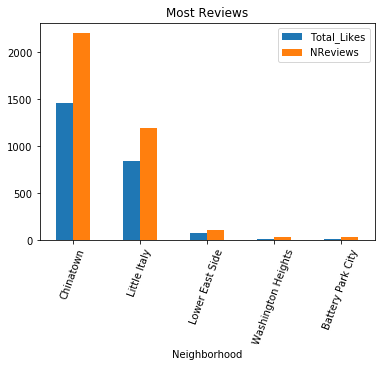

In [310]:
compare.plot.bar(x="Neighborhood", y={"NReviews", "Total_Likes"}, rot=70, title= "Most Reviews")

Chinatown is ideal since it has 50% of its restaurant market in Chinese restaurants ad all fall in cheap price category.
Little Italy is potential other location for its more popularity.


In [311]:
a_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Chinatown,Chinese Restaurant,American Restaurant,Vietnamese Restaurant
2,Washington Heights,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant
3,Inwood,Mexican Restaurant,Restaurant,Chinese Restaurant
4,Hamilton Heights,Mexican Restaurant,Sushi Restaurant,Indian Restaurant
5,Manhattanville,Seafood Restaurant,Italian Restaurant,Sushi Restaurant
6,Central Harlem,African Restaurant,Chinese Restaurant,American Restaurant
7,East Harlem,Mexican Restaurant,Latin American Restaurant,Thai Restaurant
19,East Village,Mexican Restaurant,Japanese Restaurant,Ramen Restaurant
20,Lower East Side,Chinese Restaurant,Vietnamese Restaurant,Mediterranean Restaurant
22,Little Italy,Chinese Restaurant,Mediterranean Restaurant,Thai Restaurant


In [312]:
Mexican = pandasql.sqldf("SELECT Neighborhood, Price_Category, count(Venue) as NRestaurants, avg(Ratings) as Avg_Ratings, sum(Total_Reviews) as NReviews, sum(Likes) as Total_Likes, (cast (sum(Likes) as float)/ cast (sum(Total_Reviews) as float)) as NLikesperReviewRatio FROM data where Neighborhood in ('Inwood', 'Hamilton Heights', 'East Harlem', 'East Village', 'Manhattan Valley', 'Tudor City') and Venue_Category = 'Mexican Restaurant' group by Neighborhood order by NReviews DESC", globals())
Mexican

,Neighborhood,Price_Category,NRestaurants,Avg_Ratings,NReviews,Total_Likes,NLikesperReviewRatio
0,East Village,Cheap,4,8.275000,1410,970,0.687943
1,Tudor City,Moderate,4,7.550000,1286,757,0.588647
2,East Harlem,Moderate,5,7.920000,346,219,0.632948
3,Manhattan Valley,Cheap,2,8.000000,227,148,0.651982
4,Inwood,Moderate,4,7.750000,220,155,0.704545
5,Hamilton Heights,Cheap,3,7.966667,126,87,0.690476


In [313]:
M = pandasql.sqldf("SELECT Price_Category, count(Price_Category) as Price_preference FROM data where Venue_Category = 'Mexican Restaurant' group by Price_Category", globals())
M

,Price_Category,Price_preference
0,Cheap,30
1,Expensive,6
2,Moderate,17


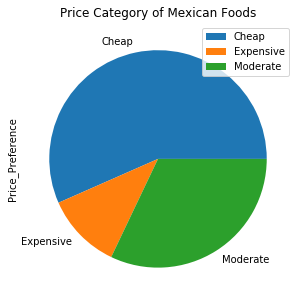

In [314]:
Mpie = pd.DataFrame({'Price_Preference': [30, 6 , 17]},
                  index=['Cheap', 'Expensive', 'Moderate'])
plot = Mpie.plot.pie(y='Price_Preference', figsize=(5, 5), title= "Price Category of Mexican Foods")

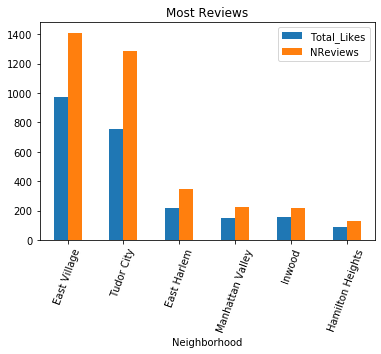

In [315]:
Mexican.plot.bar(x="Neighborhood", y={"NReviews", "Total_Likes"}, rot=70, title= "Most Reviews")

In [316]:
Mxx = pandasql.sqldf("SELECT Price_Category, count(Price_Category) as Preference FROM data where Neighborhood in ('Midtown South') group by Price_Category order by Preference", globals())
Mxx

,Price_Category,Preference
0,Very Expensive,1
1,Expensive,2
2,Moderate,5


Here, East Village has most reviews, most ratings, most likes and also cheap, hence ideal for a Mexican Restaurant Location.
Now, between Tudor City, Manhattan Valley, and Hamilton Heights being 2nd, 3rd, 4th most rated.
Manhattan Valley is a potential location for its low Nrestaurants,cheap price category and good ratings and also better in Overall customer attraction with being above others in Nreviews_as_Ncustomers ranklist.

In [317]:
b_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,Midtown,Japanese Restaurant,Cuban Restaurant,Mediterranean Restaurant
16,Murray Hill,Japanese Restaurant,Mediterranean Restaurant,Indian Restaurant
17,Chelsea,American Restaurant,Italian Restaurant,Seafood Restaurant
26,Morningside Heights,American Restaurant,Mexican Restaurant,Ethiopian Restaurant
29,Financial District,American Restaurant,Falafel Restaurant,Japanese Restaurant
30,Carnegie Hill,Japanese Restaurant,Italian Restaurant,French Restaurant
31,Noho,Italian Restaurant,Japanese Restaurant,Mexican Restaurant
32,Civic Center,French Restaurant,American Restaurant,Sushi Restaurant
33,Midtown South,Korean Restaurant,Japanese Restaurant,American Restaurant
38,Flatiron,Italian Restaurant,Mediterranean Restaurant,Japanese Restaurant


In [318]:
Japenese = pandasql.sqldf("SELECT Neighborhood, Price_Category, count(Venue) as NRestaurants, avg(Ratings) as Avg_Ratings, sum(Total_Reviews) as NReviews, sum(Likes) as Total_Likes, (cast (sum(Likes) as float)/ cast (sum(Total_Reviews) as float)) as NLikesperReviewRatio FROM data where Neighborhood in ('Carnegie Hill', 'Murray Hill', 'Midtown South') and Venue_Category = 'Japanese Restaurant' group by Neighborhood order by NReviews DESC", globals())
Japenese

,Neighborhood,Price_Category,NRestaurants,Avg_Ratings,NReviews,Total_Likes,NLikesperReviewRatio
0,Murray Hill,Very Expensive,3,8.433333,1417,1020,0.719831
1,Midtown South,Moderate,4,8.550000,1122,865,0.770945
2,Carnegie Hill,Moderate,3,8.200000,313,197,0.629393


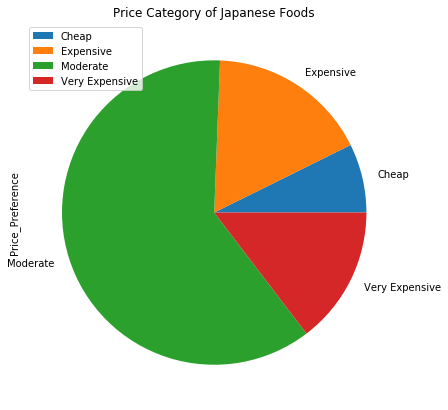

In [319]:
Jpie = pd.DataFrame({'Price_Preference': [3, 7 , 25, 6]},
                  index=['Cheap', 'Expensive', 'Moderate', 'Very Expensive'])
plot = Jpie.plot.pie(y='Price_Preference', figsize=(7, 7), title= "Price Category of Japanese Foods")

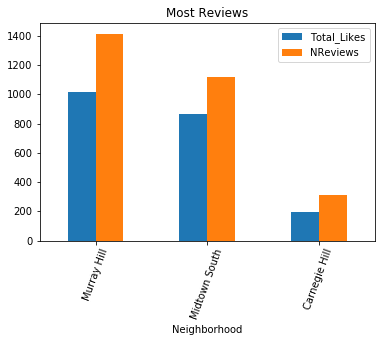

In [320]:
Japenese.plot.bar(x="Neighborhood", y={"NReviews", "Total_Likes"}, rot=70, title= "Most Reviews")

In [321]:
J = pandasql.sqldf("SELECT Price_Category, count(Price_Category) as Price_preference FROM data where Venue_Category = 'Japanese Restaurant' group by Price_Category", globals())
J

,Price_Category,Price_preference
0,Cheap,3
1,Expensive,7
2,Moderate,25
3,Very Expensive,6


For Japanese, though majority restaurants are in moderate price category, customers prefer expensive venues more, 
and Murray has more reviews and likes so Murray Hill is ideal location.
Next Midtown South is a potential location.

In [322]:
American = pandasql.sqldf("SELECT Neighborhood, Price_Category, count(Venue) as NRestaurants, avg(Ratings) as Avg_Ratings, sum(Total_Reviews) as NReviews, sum(Likes) as Total_Likes, (cast (sum(Likes) as float)/ cast (sum(Total_Reviews) as float)) as NLikesperReviewRatio FROM data where Neighborhood in ('Chelsea', 'Morningside Heights', 'Financial District') and Venue_Category = 'American Restaurant' group by Neighborhood order by NReviews DESC", globals())
American

,Neighborhood,Price_Category,NRestaurants,Avg_Ratings,NReviews,Total_Likes,NLikesperReviewRatio
0,Chelsea,Expensive,3,8.800000,4167,3042,0.730022
1,Financial District,Expensive,5,8.160000,1275,943,0.739608
2,Morningside Heights,Expensive,3,8.066667,1052,721,0.685361


In [323]:
A = pandasql.sqldf("SELECT Price_Category, count(Price_Category) as Price_preference FROM data where Venue_Category = 'American Restaurant' group by Price_Category", globals())
A

,Price_Category,Price_preference
0,Cheap,1
1,Expensive,12
2,Moderate,47
3,Very Expensive,4


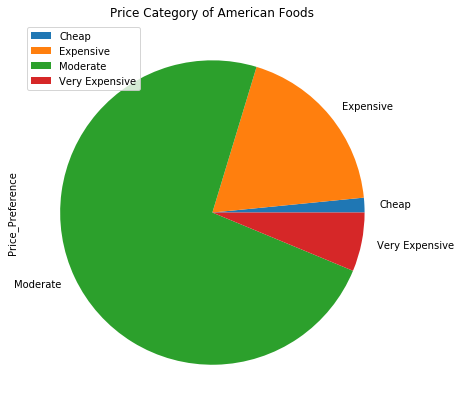

In [324]:
Apie = pd.DataFrame({'Price_Preference': [1, 12 , 47, 4]},
                  index=['Cheap', 'Expensive', 'Moderate', 'Very Expensive'])
plot = Apie.plot.pie(y='Price_Preference', figsize=(7, 7), title= "Price Category of American Foods")

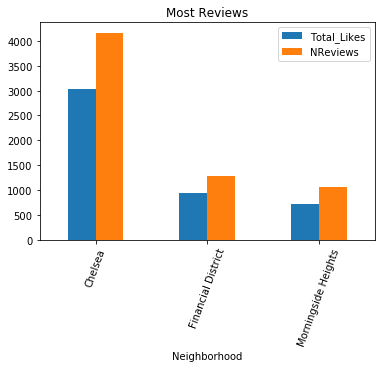

In [325]:
American.plot.bar(x="Neighborhood", y={"NReviews", "Total_Likes"}, rot=70, title= "Most Reviews")

For American, customers prefer expensive venues more, and Chelsea has more reviews so Chelsea is ideal location.
Next Morningside Heights is a potential location with low Nnrestaurants and comparable total reviews.

In [326]:
c_cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
8,Upper East Side,Italian Restaurant,Sushi Restaurant,American Restaurant
9,Yorkville,Italian Restaurant,Sushi Restaurant,Japanese Restaurant
10,Lenox Hill,Italian Restaurant,Sushi Restaurant,Turkish Restaurant
12,Upper West Side,Italian Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant
13,Lincoln Square,Italian Restaurant,American Restaurant,French Restaurant
14,Clinton,Italian Restaurant,American Restaurant,Thai Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Indian Restaurant
21,Tribeca,Italian Restaurant,American Restaurant,Greek Restaurant
23,Soho,Italian Restaurant,Mediterranean Restaurant,Sushi Restaurant
24,West Village,Italian Restaurant,American Restaurant,New American Restaurant


In [327]:
Italian = pandasql.sqldf("SELECT Neighborhood, Price_Category, count(Venue) as NRestaurants, avg(Ratings) as Avg_Ratings, sum(Total_Reviews) as NReviews, sum(Likes) as Total_Likes, (cast (sum(Likes) as float)/ cast (sum(Total_Reviews) as float)) as NLikesperReviewRatio FROM data where Neighborhood in (select Neighborhood from c_cluster where `1st Most Common Venue` = 'Italian Restaurant') and Venue_Category = 'Italian Restaurant' group by Neighborhood order by NReviews DESC", globals())
Italian

,Neighborhood,Price_Category,NRestaurants,Avg_Ratings,NReviews,Total_Likes,NLikesperReviewRatio
0,Soho,Expensive,6,8.850000,6503,4736,0.728279
1,Greenwich Village,Very Expensive,8,8.862500,3984,2978,0.747490
2,West Village,Expensive,6,8.366667,3219,2261,0.702392
3,Tribeca,Expensive,5,8.280000,2600,1863,0.716538
4,Gramercy,Expensive,4,8.150000,2424,1738,0.716997
5,Lenox Hill,Moderate,5,8.000000,1190,837,0.703361
6,Upper West Side,Moderate,3,8.533333,1146,783,0.683246
7,Upper East Side,Very Expensive,7,8.157143,859,590,0.686845
8,Lincoln Square,Moderate,5,7.460000,811,475,0.585697
9,Sutton Place,Very Expensive,4,8.475000,785,569,0.724841


In [328]:
I = pandasql.sqldf("SELECT Price_Category, count(Price_Category) as Price_preference FROM data where Venue_Category = 'Italian Restaurant' group by Price_Category", globals())
I

,Price_Category,Price_preference
0,Cheap,2
1,Expensive,28
2,Moderate,55
3,Very Expensive,15


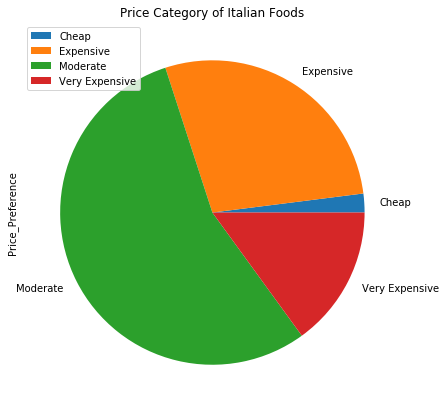

In [329]:
Ipie = pd.DataFrame({'Price_Preference': [2, 28 , 55, 15]},
                  index=['Cheap', 'Expensive', 'Moderate', 'Very Expensive'])
plot = Ipie.plot.pie(y='Price_Preference', figsize=(7, 7), title= "Price Category of Italian Foods")

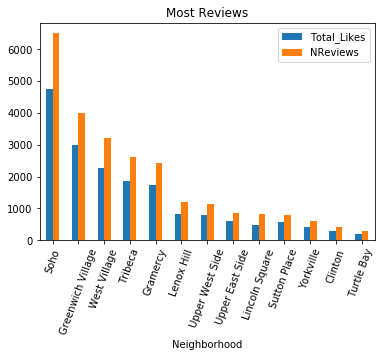

In [330]:
Italian.plot.bar(x="Neighborhood", y={"NReviews", "Total_Likes"}, rot=70, title= "Most Reviews")

In [331]:
Italian.to_csv('Italian.csv')

For Italian, customers prefer Expensive food, and Soho is most reviewed that is almost twice of Greenwich Village which is very expensive.
Hence, Soho is ideal.
Tribeca has around 42% of its restaurant market in Italian and ranked 6th in most reviewed restaurants. Hence, it may be a potential.


## 7. Results

In [332]:
d_r = {'Restaurant Category' : ['Chinese', 'Mexican', 'Japenese', 'American', 'Italian'],
       'Ideal Neighborhood Location' : ['Chinatown', 'East Village', 'Murray Hill', 'Chelsea', 'Soho'],
        'Potential Neighborhood Location' : ['Little Italy', 'Manhattan Valley', 'Midtown South', 'Morningside Heights', 'Tribeca']}

In [333]:
final_results = pd.DataFrame(d_r)

In [334]:
final_results

,Restaurant Category,Ideal Neighborhood Location,Potential Neighborhood Location
0,Chinese,Chinatown,Little Italy
1,Mexican,East Village,Manhattan Valley
2,Japenese,Murray Hill,Midtown South
3,American,Chelsea,Morningside Heights
4,Italian,Soho,Tribeca
